На основе данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах проведем исследование рынка компьютерных игр.  

Цель исследования — выявление определяющих успешность игры закономерностей

Данные о поведении пользователей получены из открытых источников и представленны в файле games.csv.

Исследование пройдёт в четыре этапа: 
- Обзор данных. 
- Предобработка данных. 
- Проведение исследовательского анализа данных. 
- Проверка статистических гипотез

###  Откроем файл с данными и изучим общую информацию

In [28]:
# импортируем библиотеки и загрузим датасет
# рассмотрим первые 5 строк таблицы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")

try:
    data=pd.read_csv('/datasets/games.csv')
except:
    data=pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Рассмотрим общую информацию о датасете

In [29]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


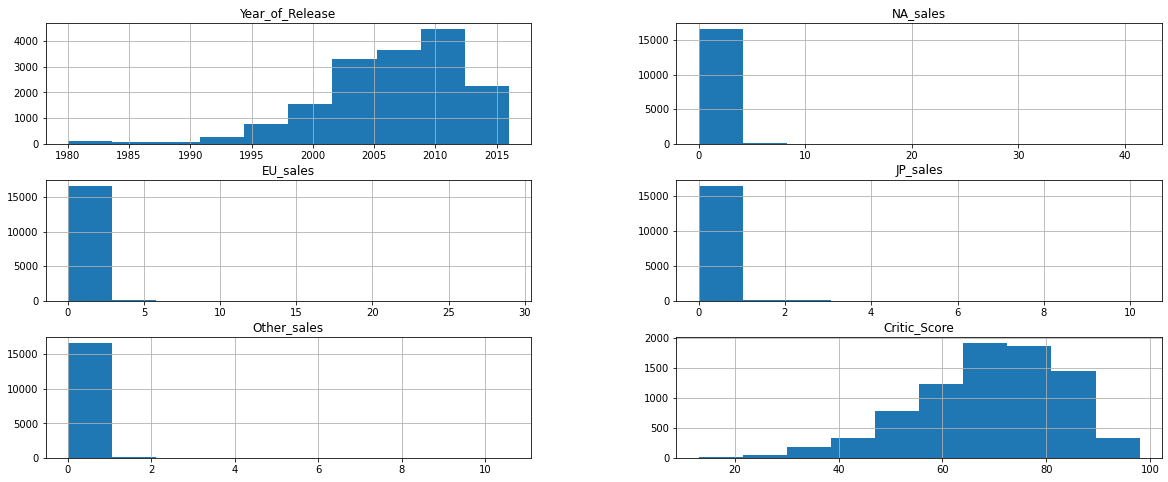

In [30]:
data.hist(figsize=(20, 8));

In [31]:
# Оценим полноту данных
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
Name,0.000000
Platform,0.000000
Year_of_Release,1.600000
Genre,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.300000
User_Score,40.100000


Проверим на наличие явных дубликатов

In [32]:
data.duplicated().sum()

0

Вывод: В датасете 16 715 строк и 11 столбцов. В некоторых столбцах пропущенные значения достигают 51%. ряд столбцов содержит некорректный тип данных. Наименования столбцов для удобства следует привести к нижнему регистру.

### Предобработка данных

Заменим названия столбцов и приведем их к нижнему регистру.

In [33]:
#переименование колонок (исправление стиля)
data.columns = data.columns.map(lambda x: x.lower())

#проверим внесение изменений:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [34]:
#чтобы избежать повторяющихся действий создадим функцию для описания столбцов
def description(column):
    print('наименование столбца:',column)
    print('тип данных:', data[column].dtypes)
    print('пропущенно значений:',data[column].isna().sum())
    if data[column].dtypes == 'object':
        print('уникальные значения:', '\n', data[column].value_counts())
    else:
        print('минимальное значение:',data[column].min())
        print('максимальное значение:', data[column].max())

Вначале оценим столбец с названиями игр (name)

In [35]:
description('name')

наименование столбца: name
тип данных: object
пропущенно значений: 2
уникальные значения: 
 Need for Speed: Most Wanted                             12
Madden NFL 07                                            9
Ratatouille                                              9
FIFA 14                                                  9
LEGO Marvel Super Heroes                                 9
                                                        ..
Blazer Drive                                             1
Pirates of the Caribbean: The Legend of Jack Sparrow     1
Game & Watch Gallery 2                                   1
Yu-Gi-Oh! Double Pack                                    1
SingStar Party                                           1
Name: name, Length: 11559, dtype: int64


Пропущенно всего 2 значения. 

In [36]:
# Удаляем записи, где отсутствует название игры (невозможно востановить данную информацию)
data.dropna(subset=['name'], inplace=True)
# контрольная проверка наличия пропусков в столбце
data['name'].isnull().sum()

0

Рассмотрим столбец с указанием платформы (platform)

In [37]:
description('platform')

наименование столбца: platform
тип данных: object
пропущенно значений: 0
уникальные значения: 
 PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       27
NG        12
WS         6
SCD        6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64


Пропущенных значений нет. Возникли сомнения в правильности записи наименования платформы '2600'. Поиск информации показал, что это не опечатка а сокращенное наименование 'Atari 2600' (популярная с 1977 по 1990 приставка)

Рассмотрим столбец с указанием года выхода (year_of_release)

In [38]:
description('year_of_release')

наименование столбца: year_of_release
тип данных: float64
пропущенно значений: 269
минимальное значение: 1980.0
максимальное значение: 2016.0


In [39]:
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [40]:
# Приводим в целочисленный тип год выхода игры
# Удалим попущенные значения
data.dropna(subset=['year_of_release'], inplace=True)
data['year_of_release'] = data['year_of_release'].astype(int)

# Проверим 
data['year_of_release'].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983])

Рассмотрим столбец с указанием жанра (genre)

In [41]:
description('genre')

наименование столбца: genre
тип данных: object
пропущенно значений: 0
уникальные значения: 
 Action          3307
Sports          2306
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       857
Fighting         837
Strategy         673
Puzzle           569
Name: genre, dtype: int64


Рассмотрим столбцы по продажам(na_sales,eu_sales,jp_sales,other_sales )
Данные записанны в миллионах проданных копий

In [93]:
description('na_sales')
print('-'* 30)
description('eu_sales')
print('-'* 30)
description('jp_sales')
print('-'* 30)
description('other_sales')

наименование столбца: na_sales
тип данных: float64
пропущенно значений: 0
минимальное значение: 0.0
максимальное значение: 41.36
------------------------------
наименование столбца: eu_sales
тип данных: float64
пропущенно значений: 0
минимальное значение: 0.0
максимальное значение: 28.96
------------------------------
наименование столбца: jp_sales
тип данных: float64
пропущенно значений: 0
минимальное значение: 0.0
максимальное значение: 10.22
------------------------------
наименование столбца: other_sales
тип данных: float64
пропущенно значений: 0
минимальное значение: 0.0
максимальное значение: 10.57


Рассмотрим оценки критиков и игроков (critic_score, user_score)

In [43]:
description('critic_score')
print('-'* 30)
description('user_score')

наименование столбца: critic_score
тип данных: float64
пропущенно значений: 8461
минимальное значение: 13.0
максимальное значение: 98.0
------------------------------
наименование столбца: user_score
тип данных: object
пропущенно значений: 6605
уникальные значения: 
 tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.5       2
1         2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64


В оценках критиков мы видим 8 461 пропуск. Это может быть вызванно не правильной загрузкой данных или тем, что игра относительно новая и еще не успела получить оценку.

В оценках пользлвателей мы видим необычный показатель tbd "будет определено позже". Также необходимо изменить тип данных на float.

In [44]:
# заменим tbd на nan.
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan
# Изменим тип данных на float
data['user_score'] = data['user_score'].astype('float')
data['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

Мы не стали удалять пропущенные значения, т.к. они составляют практически половину датасета и это может сильно исказить другие вычисления.

Рассмотрим столбец с обозначением рейтинга от организации ESRB (rating)

In [51]:
description('rating')

наименование столбца: rating
тип данных: object
пропущенно значений: 0
уникальные значения: 
 unknown    6676
E          3924
T          2905
M          1536
E10+       1393
EC            8
AO            1
RP            1
Name: rating, dtype: int64


Рейтинг К-А присваивали играм, содержащим контент, подходящий для широкой аудитории. Этот рейтинг использовался до 1998 года, когда он был переименован в E. Заменим значение К-А на Е для единообразия.

In [46]:
data['rating']= data['rating'].str.replace('K-A', 'E')
# проверка
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

Мы видим 6676 пропусков. Возможно это данные по играм выпущенным до 1994 года (год создания рейтингового агентства).

In [47]:
data.groupby(['year_of_release'])['rating'].count()

year_of_release
1980       0
1981       0
1982       0
1983       0
1984       0
1985       1
1986       0
1987       0
1988       1
1989       0
1990       0
1991       0
1992       2
1993       0
1994       1
1995       0
1996       7
1997      19
1998      32
1999      42
2000     148
2001     339
2002     655
2003     613
2004     598
2005     706
2006     678
2007     821
2008     981
2009    1011
2010     799
2011     703
2012     355
2013     316
2014     345
2015     315
2016     280
Name: rating, dtype: int64

Заполним пропуски новой категорией "unknown"

In [48]:
data['rating'] = data['rating'].fillna(value='unknown')
# проверка
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

Расчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец.

In [49]:
data['total_sales']=data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
# проверка
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


Вывод: Наименования солбцов были приведены к нижнему регистру. Из столбцов с наименованиями и годом выпуска были удалены строки, т.к. эти данные невозможно востановить. Пропуски в других столбцах не привели к удалению строк,но и не были заполненны т.к. это может повлечь за собой некорректные расчеты. Создан  дополнительный столбец с суммарными продажами по всем регионам. Все данные приведены к удобным для работы форматам.

In [50]:
#проверка на явные дубли
data.duplicated().sum()

0

### Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы. 

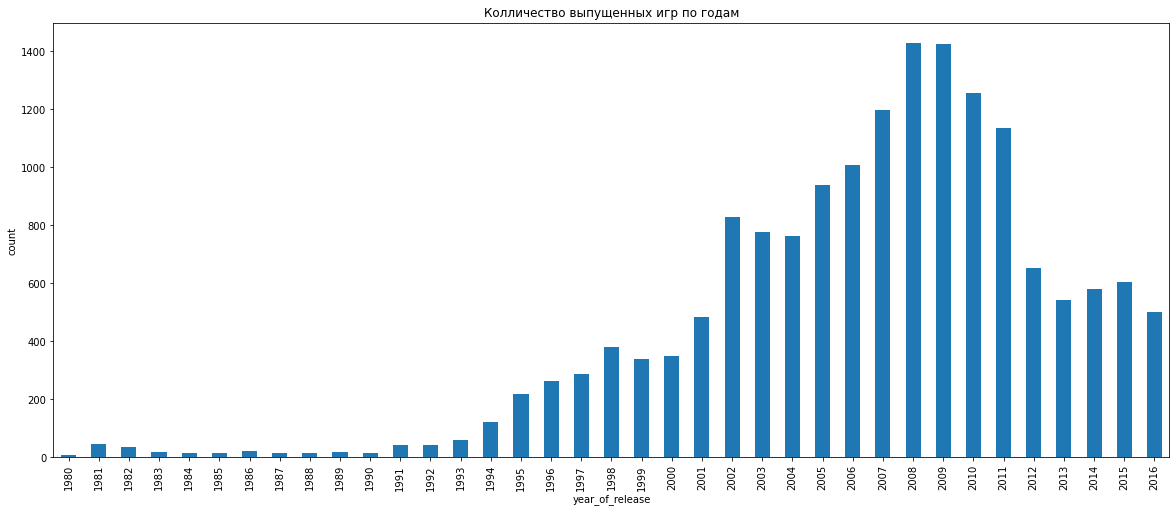

In [52]:
data.groupby(by='year_of_release')['year_of_release'].count().plot(kind='bar', 
                                                                   ylabel = 'count', 
                                                                   title='Колличество выпущенных игр по годам',
                                                                   figsize=(20,8));

 Можно отметить резкие скачки в 1994, а затем в 2002 году. А уже с 2010 наблюдется устойчивый спад, в колличестве выпускаемых игр.
Такм образом данные до 1994 года можно отбросить. Наибольший интерес для нас будут представялять игры выпущенные с 2014 до 2016 года.

Рассмотрим, как менялись продажи по платформам.

Выберем платформы с наибольшими суммарными продажами.

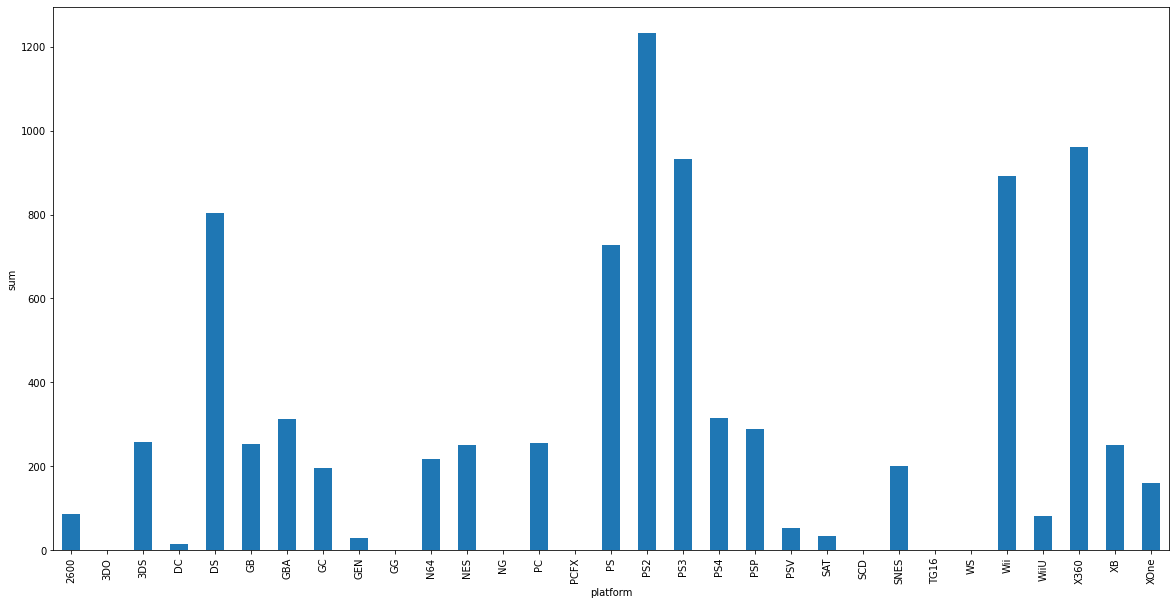

In [23]:
data.groupby(by='platform')['total_sales'].sum().plot(kind='bar', ylabel = 'sum', figsize=(20,10));

In [53]:
(
    data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
    .sort_values(by = 'total_sales', ascending = False)
)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Исходя из иформации представленно на графике, можно выделить Топ-10 наиболее популярных платформ.

Топ-10:
- PS2
- X360
- PS3
- Wii
- DS
- PS
- PS4	
- GBA	
- PSP	
- 3DS

Построим распределение по годам для топ-10 платформ. 

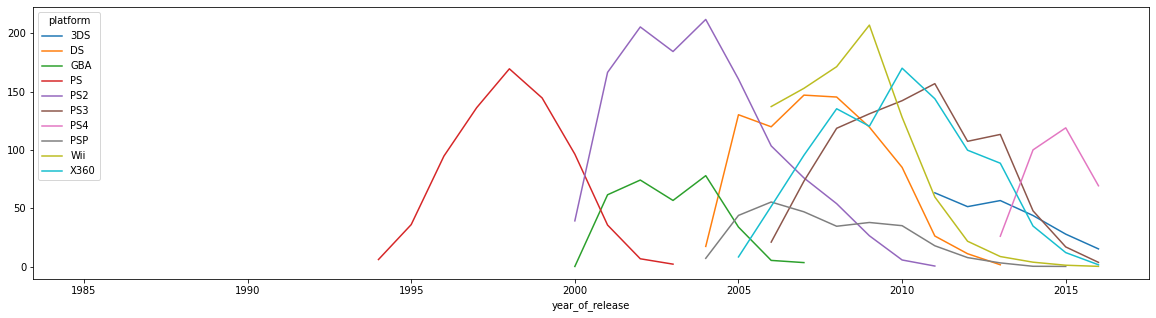

In [54]:
top_p = data.groupby('platform').sum()['total_sales'].sort_values(ascending=False).index.values[:10]

popular_p = data[data.platform.isin(top_p)]
popular_p = popular_p.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
popular_p.plot(figsize=(20,5));

Вывод: Судя по графику в среднем каждые 5 лет на рынке появляется от 1 до 3 новых платформ. При этом средний срок жизни платформы составляет примерно 10 лет. На графике видно, что большинство платформ из нашего списка (топ по продажам за весь период существования) к 2016 году потеряли былую популярность. Только PS4 показывет относительно высокие продажи, но сохраняет тенденцию к падению. Также следует отметить, что на даных график могли не попасть молодые активно растущие платформы, которые составляют для нас наибольший интерес.

Для постороения прогноза на 2017 год, необходимо обратиться к данным отражающим современную рыночную ситуацию.  
Наиболее актуальным периодом представляется 3 года (с 2014 по 2016). 
Данные за предыдущие годы учитывать не будем. 

In [55]:
# создадим урезанную версию датасета только с данными за актуальные годы
new_data = data.query('year_of_release >= 2014')
# посмотрим коллиечтво уникальных платформ
new_data['platform'].unique()

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV',
       'PSP'], dtype=object)

Какие платформы лидируют по продажам, растут или падают

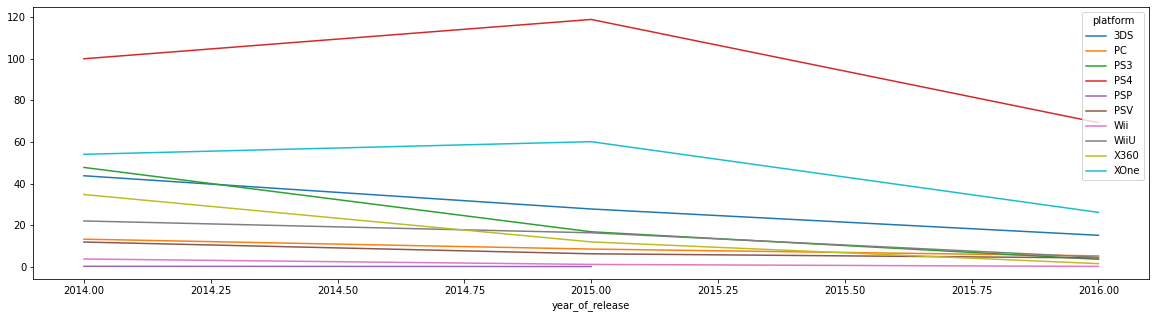

In [56]:
new_data_pivot_table = new_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
new_data_pivot_table.plot(figsize=(20,5));

К 2016 году все платформы испытывают спад. Данные могут быть несколько искажены, т.к. по 2016 могут быть не полными.

Платформа окончательно PSP окончательно потеряла своих клиентов.

Наиболее высокие продажи показывают PS4,3DS и XOne.

Несмотря на относительно низкие продажи PSV и PC уже достаточно долго сохраняют свои позиции на рынке на одном уровне.

Наиболее вероятные кандидаты на уход с рынка в ближайшем будующем PS3, X360, WiiU и Wii

Таким образом к потенциально прибыльным платформам можно отнести PS4,3DS и XOne. А так же PSV и PC, т.к. им удается сохранять лояльность своей аудитории длительный срок.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

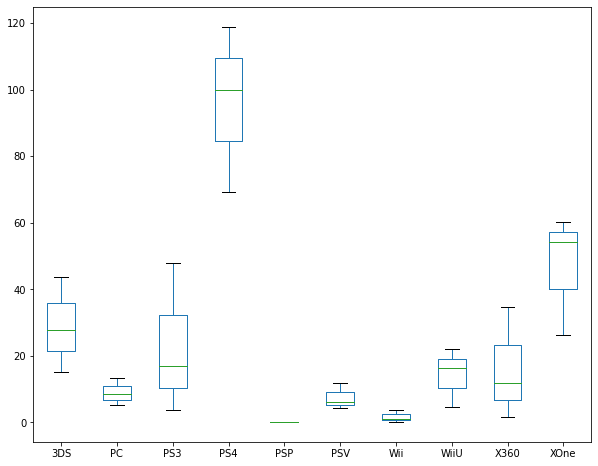

In [57]:
new_data_pivot_table.plot(kind='box',figsize=(10,8));

Согласно графику больше всего игр в период с 2012 по 2016 годы продали PS4, X360, PS3, XOne и 3DS.
При этом самый высокий медианный паказатель у PS4, что характеризует эту платформу как потенциально наиболее прибыльную.

Посмотрим, как влияют на продажи внутри PS4 отзывы пользователей и критиков. 

Построим диаграмму рассеяния 

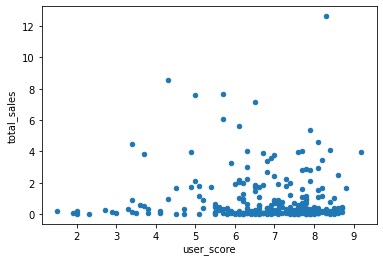

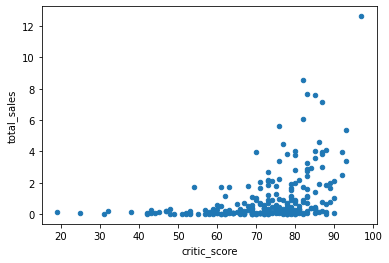

In [58]:
PS4 = data.query('platform == "PS4"')
PS4.plot(x='user_score', y='total_sales', kind='scatter');
PS4.plot(x='critic_score', y='total_sales', kind='scatter');

Посчитаем корреляцию между отзывами и продажами.

In [59]:
PS4_cor = PS4[['critic_score','user_score', 'total_sales']]
PS4_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000


Исходя из расчета корреляции мы видим слабую взаимосвязь между оценкой критиков и уровнем продаж. Но усиановать причинно-следственную связь не возможно. Уделяют ли внимание критики только самым продоваемым играм? оказываются ли самые продоваемые игры максимально качественными?

В тоже время оценка игроков с уровнем продаж практически не взаимосвязанна.
Посмотрим на корреляцию критики с продажами игр на других платформах из нашего топа.

In [60]:
all_corr = data.query('platform == [ "XOne", "PS3", "X360", "3DS" ]')
all_corr = all_corr[['platform','critic_score','user_score', 'total_sales']]
all_corr.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.613633,0.401241
user_score,0.613633,1.000000,0.118579
total_sales,0.401241,0.118579,1.000000


Картина сохранилась для всех платформ

Посмотрим на общее распределение игр по жанрам.  

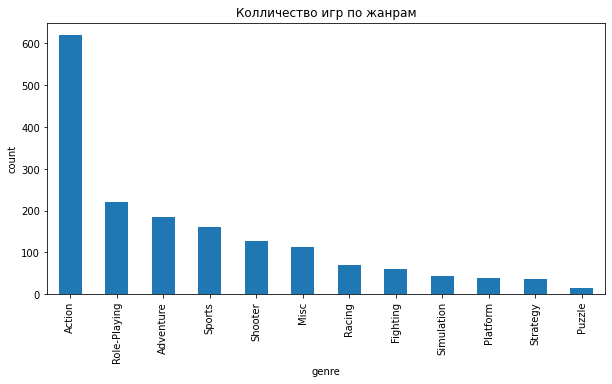

In [65]:
(
    new_data.groupby(by='genre')['genre']
         .count()
         .sort_values(ascending=False)
         .plot(kind='bar',ylabel = 'count',title='Колличество игр по жанрам', figsize=(10,5))
);

Лидерами по колличеству продаж являются игры в жанрах:
- Action
- Role-Playing
- Adventure

Рассмотрим самые прибыльные жанры

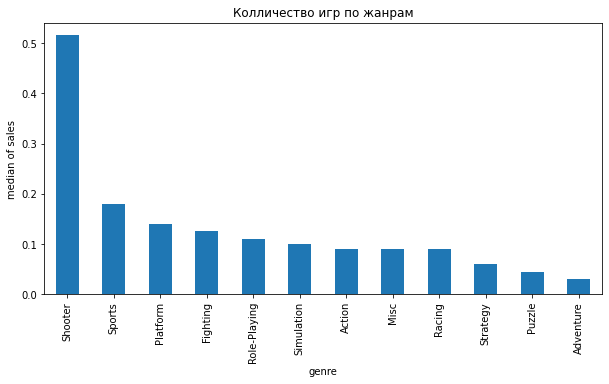

In [118]:
(
    new_data.groupby(by='genre')['total_sales']
         .median()
         .sort_values(ascending=False)
         .plot(kind='bar',ylabel = 'median of sales',title='Колличество игр по жанрам', figsize=(10,5))
);

Наиболее прибыльными жанрами можно назвать:
- Shooter
- Sports
- Platform
- Fighting
- Role - Playing

При этом игры в жанре Shooter значительно выделяются на фоне остальных, а игры в остальных жанрах значительно отстают в уровне продаж от лидера.

### Составим портрет пользователя каждого региона

Определим самые популярные платформы (топ-5) и жанры (топ -5 )для пользователя каждого региона (NA, EU, JP):

na_sales — продажи в Северной Америке 

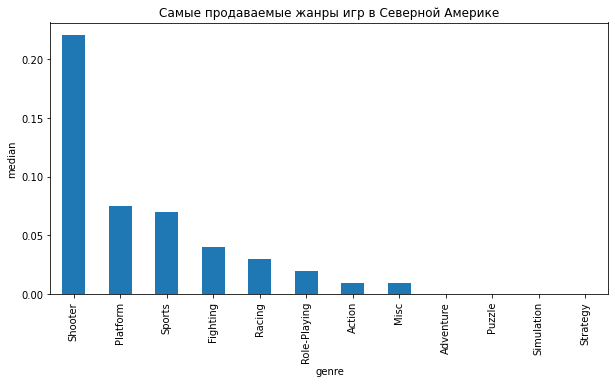

In [76]:
na_top= (
    new_data.groupby(by='genre')['na_sales']
         .median()
         .sort_values(ascending=False)      
)
na_top.plot(kind='bar',ylabel = 'median',title='Самые продаваемые жанры игр в Северной Америке', figsize=(10,5));

Топ - 5 популярных жанров в Северной Америке:

- Shooter
- Platform
- Sports
- Fighting
- Racing

Найдем Топ-5 популярных платформ в Северной Америке 

In [113]:
na_pop_platforms = new_data.groupby('platform').na_sales.median().sort_values(ascending=False)
na_pop_platforms[:5]

platform
X360    0.10
XOne    0.10
WiiU    0.09
PS4     0.05
Wii     0.04
Name: na_sales, dtype: float64

eu_sales — продажи в Европе

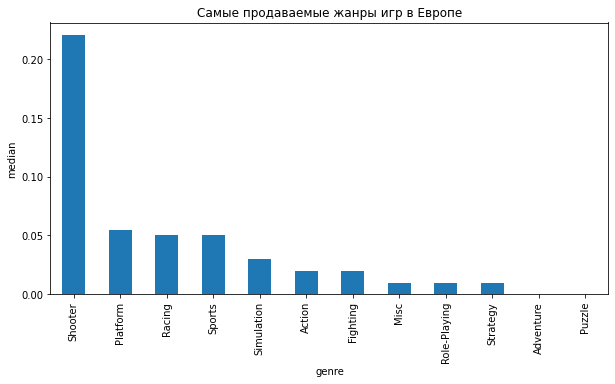

In [78]:
eu_top = (
    new_data.groupby(by='genre')['eu_sales']
         .median()
         .sort_values(ascending=False)         
)
eu_top.plot(kind='bar',ylabel = 'median',title='Самые продаваемые жанры игр в Европе', figsize=(10,5));

Топ - 5 популярных жанров в Европе:
- Shooter
- Platform
- Racing
- Sports
- Simulation

Найдем Топ-5 самых поулярных платформ в Европе

In [115]:
eu_pop_platforms = new_data.groupby('platform').eu_sales.median().sort_values(ascending=False)
eu_pop_platforms[:5]

platform
Wii     0.12
PS4     0.07
XOne    0.07
WiiU    0.06
PC      0.05
Name: eu_sales, dtype: float64

jp_sales — продажи в Японии 

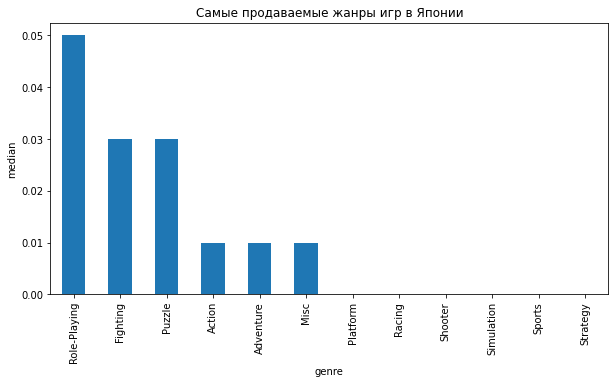

In [87]:
jp_top= (
    new_data.groupby(by='genre')['jp_sales']
         .median()
         .sort_values(ascending=False)         
)

jp_top.plot(kind='bar',ylabel = 'median',title='Самые продаваемые жанры игр в Японии', figsize=(10,5));

Топ - 5 популярных жанров в Японии:
- Role-Playing
- Fighting
- Puzzle
- Action
- Adventure


Найдем Топ-5 популрных платформ в Японии

In [114]:
jp_pop_platforms = new_data.groupby('platform').jp_sales.median().sort_values(ascending=False)
jp_pop_platforms[:5]

platform
3DS    0.055
PSV    0.030
PS3    0.020
PSP    0.020
PS4    0.015
Name: jp_sales, dtype: float64

Рассмотрим различия в долях продаж по платформам


In [133]:
pop_data = pd.DataFrame(data=[na_pop_platforms,eu_pop_platforms, jp_pop_platforms])#.T
#pop_data.plot(kind='pie',subplots=True, autopct='%0.0f%%', figsize=(20,10));


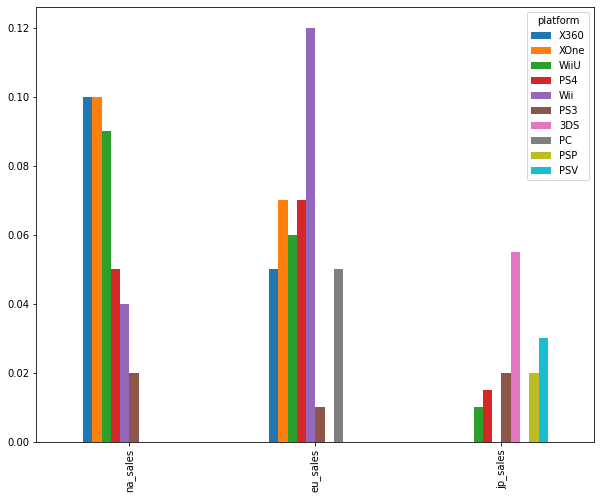

In [134]:
pop_data.plot(kind='bar', figsize=(10,8));

Несмотря на то, что пользователи в Америке и Европе отдают предпочтение схожему набору платформ, фавориты в этих регионах различаются.

Так, в среде Американских пользователей со значительным отрывом лидируют: X360,XOne и WiiU.
На Европейском рынке абсолютным фаворитом является Wii. Второе место делят XOne и РS4.Также на Европейском рынке значительно колличество пользователей по прежнему сохраняют лояльность к платформе РС. 

Аудитория Японии значительно отличается. Наиболее популярные в Европе и Америке платформы практически не представленны на Японском рынке и занимают значительно меньший сегмент.
Судя по всему Японские пользователи предпочитают пользоваться продуктами локальных разрабочиков или имеют игровые привычки связанные с использованием других устройств. 
Так, фаворитами на рынке Японии являются: 3DS и PSV. А практически потерявшая популярность на рынке Европы и Америки PS3, делит третье место с не представленной на этих рынках PSV.

Исходя из данных отраженных на графике можно предположить, что платформы позволяющие охватить аудиторию всех рассматриваемых регионов - WiiU,РS4 и PS3.

Рассмотрим разницу в популярности жанров

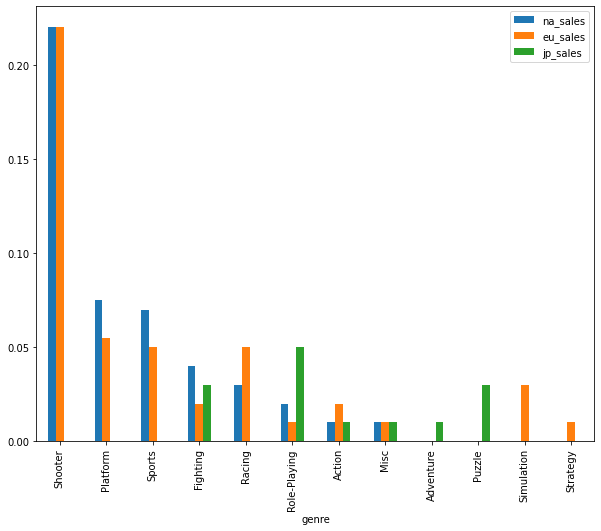

In [135]:
top_data = pd.DataFrame(data=[na_top,eu_top, jp_top]).T
top_data.plot(kind='bar',figsize=(10,8));

Можно отметить, что игровые предпочтения жителей Америки и Европы схожи.
Со значительным отрывом на этих рынках лидируют игры в жанре Shooter. Игроки в Японии предпочитают игры в жанре Role-Playing, Puzzle и Fighting, а жанр Shooter их совершенно не интересует. Практически не интерессны всем группам игроков игры в жанре Adventutr и Strategy.

Мы наблюдаем полное пересечение интересов аудитории в жанрах: Fighting, Playing, Action и Music.


Рассмотрим влияет ли рейтинг ESRB на продажи в отдельном регионе.

In [138]:
ESRB = new_data.pivot_table(index = 'rating', values = ['eu_sales','jp_sales','na_sales'], aggfunc = 'sum')
ESRB

,eu_sales,jp_sales,na_sales
rating,,,
E,58.06,8.94,50.74
E10+,26.16,4.46,33.23
M,93.44,8.01,96.42
T,34.07,14.78,38.95
unknown,58.95,56.90,64.72


Расшифровка рейтингов:

- «E» («Everyone») — «Для всех» 6+
- «E10+» («Everyone 10 and older») — «Для всех старше 10 лет»
- «M» («Mature») — «От 17 лет»
- «T» («Teen») — «Подросткам 13—19 лет»
- unknown - отсутствие рейтинговой отметки

На рынках Америки и Европы преобладают прожади игр с рейтингом M.

Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории. Данная пометка позволяет оградить подростковую аудиторию от подобного контента и при этом не относить игру в дейтинг АО, что могло бы накладывать определенные ограничения на продажу и значительно сузить аудиторию.

На втром месте на рынках Америки и Европы оказались игры из заданной нами группы unknown.Эта же группа охватыает игры наиболее популярные в Японии, но это может быть связанно с локальной системой рейтингов, которая гораздо строже ESRB.

### Проверим гипотезы

**Пояснения:**

Нулевые и альтернативные гипотезы были сформулированны основываясь на том,что H₀ всегда формулируется так, чтобы использовать знак равенства.

Так как рассматриваемые параметры не зависимы друг от друга - используем специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2, equal_var)
Значению equal_var укажем параметр False, т.к. есть сомнения, что дисперсии у совокупностей одинаковые.

Пороговое значение alpha установим на уровне 0.01

Сравним средние значения рейтингов пользовательских платформ Xbox One и PC

In [140]:
XOne = new_data[new_data['platform'] =='XOne'].user_score.dropna().values
PC = new_data[new_data['platform'] =='PC'].user_score.dropna().values
print('Средний рейтинг пользовательской платформы XOne:', XOne.mean())
print('Средний рейтинг пользовательской платформы PC:', PC.mean())

Средний рейтинг пользовательской платформы XOne: 6.594545454545456
Средний рейтинг пользовательской платформы PC: 6.298360655737705


**Проверим гипотезу:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
```
Нулевая гипотеза: Средний пользовательский рейтинг платформ Xbox One = среднему пользовательскому рейтингу платформы PC 

Альтернативная гипотеза: Средний пользовательский рейтинг платформ Xbox One ≠ среднему пользовательскому рейтингу платформы PC 


```

In [142]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(XOne,PC, equal_var = False)
# alpha = задаем значение уровня значимости
alpha =.01

print('Значение p-value:',results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Значение p-value: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


Гипотеза подтвердилась. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сравним средние пользовательские рейтинги жанров Action и Sports

In [143]:
Action = new_data[new_data['genre'] =='Action'].user_score.dropna().values 
Sports = new_data[new_data['genre'] =='Sports'].user_score.dropna().values
print('Средний пользовательский рейтинг жанра Action:', Action.mean())
print('Средний пользовательский рейтинг жанра Sports:', Sports.mean())

Средний пользовательский рейтинг жанра Action: 6.760606060606061
Средний пользовательский рейтинг жанра Sports: 5.2251968503937


**Проверим гипотезу:** Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
```
Нулевая гипотеза: Средний пользовательский рейтинг жанра Action = среднему пользовательскому рейтингу жанра Sports 

Альтернативная гипотеза: Средний пользовательский рейтинг жанра Action ≠ среднему пользовательскому рейтингу жанра Sports

```

In [145]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(Action, Sports, equal_var = False )
# alpha = задаем значение уровня значимости
alpha =.01

print('Значение p-value:',results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Значение p-value: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Гипотеза подтвердилась. Средние пользовательские рейтинги жанров Action и Sports разные

### Общий вывод

В ходе исследования был изучен датасет содержащий 16 715 строк и 11 столбцов. Строки в которых были пропущенны значения name и year_of_release были удалены. Пропущенные значения в столбцах critic_score и user_score сохранены, т.к. это отражает поведение пользователей на различных платформах.Пропущенные значения к столбце rating были заменены новым значением unknown. Типы данных столбцов были приведены к удобному для анализа виду. Наименования столбцов для удобства приведены к нижнему регистру. Создан дополнительный столбец с суммарными продажами по всем регионам. 


Резкие увеличения колличества выпускаемых игр наблюдались в 1994 и 2002 году. Но уже с 2010 наблюдется устойчивый спад. Для анализа был выбран период с 2014 до 2016 год. 

В среднем каждые 5 лет на рынке появляется от 1 до 3 новых игровых платформ. При этом средний срок жизни платформы составляет около 10 лет. По состоянию на 2016 год, только PS4 показывет относительно высокие продажи, но сохраняет тенденцию к падению. 

К 2016 году все платформы испытывают спад. Наиболее высокие продажи показывают PS4,3DS и XOne.
Несмотря на относительно низкие продажи PSV и PC уже достаточно долго сохраняют свои позиции на рынке на одном уровне.
Наиболее вероятные кандидаты на уход с рынка в ближайшем будующем PS3, X360, WiiU и Wii
Таким образом к потенциально прибыльным платформам можно отнести PS4,3DS и XOne. А так же PSV и PC, т.к. им удается сохранять лояльность своей аудитории длительный срок.

Согласно графику больше всего игр в период с 2012 по 2016 годы продали PS4, X360, PS3, XOne и 3DS. При этом самый высокий медианный паказатель у PS4, что характеризует эту платформу как потенциально наиболее прибыльную.

Исходя из расчета корреляции мы видим слабую взаимосвязь между оценкой критиков и уровнем продаж. 
В тоже время оценка игроков с уровнем продаж практически не взаимосвязанна.

Наиболее прибыльными жанрами можно назвать:Shooter,Sports,Platform,
При этом игры в жанре Shooter значительно выделяются на фоне остальных, а игры в остальных жанрах значительно отстают в уровне продаж от лидера.

**Портрет пользователя в Северной Америке:**

Популярные жанры:Shooter, Platform, Sports, Fighting, Racing.

Популярные платформы: X360, XOne, WiiU, PS4, Wii.

**Портрет пользователя в Европе:**

Популярные жанры:Shooter, Platform, Racing, Sports, Simulation.

Популярные платформы: Wii, PS4, XOne, WiiU, PC.


**Портрет пользователя в Японии:**

Популярные жанры: Role-Playing, Fighting, Puzzle, Action, Adventure.

Популярные платформы: 3DS, PSV, PS3, PSP, PS4.


Несмотря на то, что пользователи в Америке и Европе отдают предпочтение схожему набору платформ, фавориты в этих регионах различаются.
Так, в среде Американских пользователей со значительным отрывом лидируют: X360,XOne и WiiU. 

На Европейском рынке абсолютным фаворитом является Wii. Второе место делят XOne и РS4.Также на Европейском рынке значительно колличество пользователей по прежнему сохраняют лояльность к платформе РС.

Аудитория Японии значительно отличается. Наиболее популярные в Европе и Америке платформы практически не представленны на Японском рынке и занимают значительно меньший сегмент. Судя по всему Японские пользователи предпочитают пользоваться продуктами локальных разрабочиков или имеют игровые привычки связанные с использованием других устройств. 

Так, фаворитами на рынке Японии являются: 3DS и PSV. А практически потерявшая популярность на рынке Европы и Америки PS3, делит третье место с не представленной на этих рынках PSV.


Исходя из данных отраженных на графике можно предположить, что платформы позволяющие охватить аудиторию всех рассматриваемых регионов - WiiU,РS4 и PS3.

Можно отметить, что игровые предпочтения жителей Америки и Европы схожи. Со значительным отрывом на этих рынках лидируют игры в жанре Shooter. Игроки в Японии предпочитают игры в жанре Role-Playing, Puzzle и Fighting, а жанр Shooter их совершенно не интересует. Практически не интерессны всем группам игроков игры в жанре Adventutr и Strategy.

Мы наблюдаем полное пересечение интересов аудитории в жанрах: Fighting, Playing, Action и Music.

На рынках Америки и Европы преобладают прожади игр с рейтингом M.
Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории. Данная пометка позволяет оградить подростковую аудиторию от подобного контента и при этом не относить игру в рейтинг АО, что могло бы накладывать определенные ограничения на продажу и значительно сузить аудиторию.
На втром месте на рынках Америки и Европы оказались игры из заданной нами группы unknown.Эта же группа охватыает игры наиболее популярные в Японии, но это может быть связанно с локальной системой рейтингов, которая гораздо строже ESRB.

Определяющей успешность игры закономерностью явлеяется разработка игр в наиболее популярном в регионе жанре с учетом особенностей игрового поведения заключающихся в выборе игровой платформы.

Таким образом можно предположить популярность:

Одновременно для рынков Америки, Европы и Японии игры в жанре Fighting на платформе  WiiU или РS4 с рейтингом М.

Для рынков Америки и Европы игры в жанре Shooter на платформе XOne и PC с рейтингом М.

Для рынка Японии игры в жанре Role-Playing на платформе 3DS или PSV с учетом локальных особенностей присвоения рейтинга.